### 作業
理解範例後請嘗試將關鍵點畫在圖像上，確保圖像及資料有正確讀取。
Hint: 可以用 [matplotlib 的 scatter](https://matplotlib.org/3.1.1/gallery/shapes_and_collections/scatter.html) 或者 [opencv 的 cv2.circle](https://docs.opencv.org/master/dc/da5/tutorial_py_drawing_functions.html)

### 範例
接下來的程式碼會示範如何讀取 kaggle facial keypoint detection 資料集

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [ ]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [ ]:
# 如果要使用 kaggle API 下載資料的話，請用以下程式碼
# os.environ['KAGGLE_USERNAME'] = '____' # 請按照 Day42 簡報內容，獲取 kaggle api 需要用到的 username
# os.environ['KAGGLE_KEY'] = '____' # 請按照 Day42 簡報獲取 kaggle api 需要用到的 key
# !kaggle competitions download -c facial-keypoints-detection
# !unzip test.zip
# !unzip training.zip

### 資料前處理
資料分為兩部分，一個是關鍵點坐標，總共 15 個關鍵點，所以坐標相關的值有 15 x 2 = 30 維；
另外還有 96 x 96 的灰階像素值。

讀取資料後，先簡單地過濾有缺失某些關鍵點坐標的資料，然後再把資料 scale 到 [-0.5, 0.5] 的範圍

In [60]:
# 讀取 csv 文件
DATA_ROOT = "Facial_Keypoints_Detection"
training_file = os.path.join(DATA_ROOT,"training.csv" )
data = pd.read_csv(training_file)

In [8]:
# 前 5 筆資料, .T 的作用是轉置，如果不理解可以和 data.head() 的結果相比較
data.head().T

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


In [16]:
data.shape

(7049, 31)

In [17]:
len(data['Image'][0].split(" "))

9216

用 pandas 讀取 csv 文件後可以發現前 30 個 column 是坐標值，最後一個 column 是圖片像素值的字串 (以空白鍵區隔)，接下來我們就以下的函數來做資料的讀取以及前處理，請盡量仔細理解這個函數

In [61]:
# 過濾有缺失值的 row
data = data.dropna()

# 將圖片像素值讀取為 numpy array 的形態
data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

# 單獨把圖像 array 抽取出來
imgs = np.vstack(data['Image'].values)/255
# reshape 為 96 x 96
imgs = imgs.reshape(data.shape[0], 96, 96)
# 轉換為 float
imgs = imgs.astype(np.float32)

# 提取坐標的部分
# points = data[data.columns[:-1]].to_numpy()
points = data.iloc[:, :-1].to_numpy()

# 轉換為 float
points = points.astype(np.float32)

# normalize 坐標值到 [-0.5, 0.5]
points = points/96 - 0.5

In [31]:
print("圖像資料:", imgs.shape, "\n關鍵點資料:", points.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [62]:
sample_img = imgs[0]

points = (points + 0.5)*96
sample_points = points[0]

In [63]:
x = sample_points[0::2]
y=  sample_points[1::2]

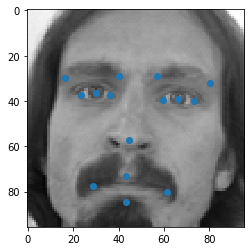

In [64]:
plt.imshow(sample_img, cmap='gray')
plt.scatter(x,y)